In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from dataloader import JPXData
from dataloader2 import SecondData
from autoencoder import encoder
import helper_functions as hf
import matplotlib.pyplot as plt
from autoencoder import autoencoder as ae

/home/aymane/Kaggle/jpx-2022/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stock_prices = pd.read_csv("modified_data/autoencoder_data.csv")

In [3]:
train_class = JPXData(data=stock_prices, model="ae")
trainloader = torch.utils.data.DataLoader(train_class, batch_size=1, shuffle=True, num_workers=5)

In [4]:
layers = [69, 50, 35, 20, 10]

In [5]:
net = ae(e_layers=layers, d_layers=layers[::-1]).cuda()

In [6]:
criterion = nn.MSELoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)

In [7]:
loss_a1 = []
loss_L1 = []
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_l1 = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, date = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = hf.loss_function(outputs, labels, criterion=lambda x,y: criterion(10*x, 10*y))
        loss_l1 = hf.loss_function(outputs, labels, criterion=nn.L1Loss().cuda())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_loss_l1 += loss_l1.item()
    
        if i % 1000 == 999: # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.5f} L1_loss: {running_loss_l1 / 1000:.5f}')
            loss_a1.append(running_loss /1000)
            loss_L1.append(running_loss_l1/1000)
            running_loss = 0.0
            running_loss_l1 = 0.0
        # torch.save(net.state_dict(), f'saved_models/{epoch}.pt')

print('Finished Training')

[1,  1000] loss: 43.66825 L1_loss: 0.45330
[2,  1000] loss: 27.24378 L1_loss: 0.34740
[3,  1000] loss: 24.41209 L1_loss: 0.32623
[4,  1000] loss: 22.33589 L1_loss: 0.31318
[5,  1000] loss: 20.04292 L1_loss: 0.29311
[6,  1000] loss: 19.54267 L1_loss: 0.28878
[7,  1000] loss: 19.11541 L1_loss: 0.28586
[8,  1000] loss: 18.60277 L1_loss: 0.28057
[9,  1000] loss: 18.42588 L1_loss: 0.27860
[10,  1000] loss: 18.03478 L1_loss: 0.27602
[11,  1000] loss: 17.83141 L1_loss: 0.27351
[12,  1000] loss: 17.44952 L1_loss: 0.27128
[13,  1000] loss: 17.10300 L1_loss: 0.26806
[14,  1000] loss: 16.84014 L1_loss: 0.26620
[15,  1000] loss: 16.84382 L1_loss: 0.26604
[16,  1000] loss: 16.71111 L1_loss: 0.26470
[17,  1000] loss: 16.55539 L1_loss: 0.26386
[18,  1000] loss: 16.25094 L1_loss: 0.26168
[19,  1000] loss: 16.19532 L1_loss: 0.26108
[20,  1000] loss: 15.85309 L1_loss: 0.25845
[21,  1000] loss: 16.03016 L1_loss: 0.25968
[22,  1000] loss: 15.78403 L1_loss: 0.25800
[23,  1000] loss: 15.53589 L1_loss: 0.256

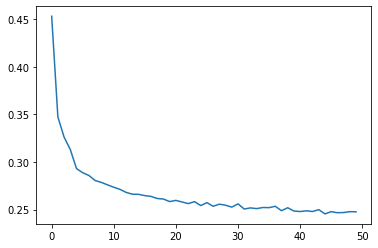

In [8]:
final_loss = np.array(loss_L1)
plt.plot(final_loss)
plt.show()

In [9]:
name = final_loss[-1]
fname = f"autoencoder_saved/ae1_l1_{name:0.3f}.pt"
net.save_state(fname)

In [10]:
e = encoder(layers) 
e.load_state_dict(torch.load(fname))
e.eval()

encoder(
  (net): Sequential(
    (0): Linear(in_features=69, out_features=50, bias=True)
    (1): SELU()
    (2): Linear(in_features=50, out_features=35, bias=True)
    (3): SELU()
    (4): Linear(in_features=35, out_features=20, bias=True)
    (5): SELU()
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): SELU()
  )
)

In [11]:
data_ae2 = SecondData(e)

In [12]:
a = data_ae2[0]
print(a[0].shape)

torch.Size([20000])


In [13]:
layers = [20000, 5000]
net2 = ae(e_layers=layers, d_layers=layers[::-1]).cuda()

In [14]:
sum = 0
for i in range(len(layers)-1):
    sum += layers[i] * layers[i+1]
print(sum*8/1e9)

0.8


In [15]:
criterion = nn.MSELoss().cuda()
optimizer = optim.SGD(net2.parameters(), lr=1e-4, momentum=0.9)

In [16]:
loss_a2 = []
loss_L1_2 = []
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_L1_2 = 0.0

    for i, data in enumerate(data_ae2, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net2(inputs)
        loss = hf.loss_function(outputs, labels, criterion=lambda x,y: criterion(10*x, 10*y))
        loss_L1_2 = hf.loss_function(outputs, labels, criterion=nn.L1Loss().cuda())
        loss.backward(retain_graph=True)
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_loss_L1_2 += loss_L1_2.item()
    
        if i % 1000 == 999: # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.5f} L1_loss: {running_loss_L1_2 / 1000:.5f}')
            loss_a2.append(running_loss /1000)
            loss_L1_2.append(running_loss_L1_2/1000)
            running_loss = 0.0
            running_loss_L1_2 = 0.0
        # torch.save(net.state_dict(), f'saved_models/{epoch}.pt')

print('Finished Training')

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.